<a href="https://colab.research.google.com/github/EddyGiusepe/Pytorch_Deep_Learning/blob/main/Red_Neural_usando_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h2 align='center'>Red Neural usando Pytorch</h2>

Data Science.: Dr.Eddy Giusepe Chirinos Isidro


Aquí, más una vez, estudiaremos la implementación de una Red Neuronal usando el FrameWork de Pytorch. El Link de estudio es de [Pepe Cantoral, PhD.](https://www.youtube.com/watch?v=qQELiV1_GHA&list=PLWzLQn_hxe6ZlC9-YMt3nN0Eo-ZpOJuXd&index=21):

* [Red Neuronal usando Pytorch](https://www.youtube.com/watch?v=qQELiV1_GHA&list=PLWzLQn_hxe6ZlC9-YMt3nN0Eo-ZpOJuXd&index=21)

# Pytorch

## Importamos las bibliotecas 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Importamos las imágenes

In [2]:
# Función para cargar los Datos de MNIST
# Ver vídeo --> https://www.youtube.com/watch?v=7cMKAlnSmpM

import gzip
import os
from os.path import isfile, join


def list_files(mnist_path):
    return [join(mnist_path,f) for f in os.listdir(mnist_path) if isfile(join(mnist_path, f))]

def get_images(mnist_path):
    for f in list_files(mnist_path):
        if 'train-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                train_images = data.read()
                x_train = np.frombuffer(train_images, dtype=np.uint8)
                x_train = x_train.reshape((num_images, rows, cols))
        elif 'train-labels' in f:
            with gzip.open(f, 'rb') as data:
                train_labels = data.read()[8:]
                y_train = np.frombuffer(train_labels, dtype=np.uint8)
        if 't10k-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                test_images = data.read()
                x_test = np.frombuffer(test_images, dtype=np.uint8)
                x_test = x_test.reshape((num_images, rows, cols))
        elif 't10k-labels' in f:
            with gzip.open(f, 'rb') as data:
                test_labels = data.read()[8:]
                y_test = np.frombuffer(test_labels, dtype=np.uint8)
    
    return x_train, y_train, x_test, y_test        

In [3]:
mnist_path = '/content/drive/MyDrive/2_DEEP_LEARNING_REDES_NEURAIS_Jorge/1_Pytorch_Deep_Learning/Pytorch_examples/Rede_neural_exemplo_Pytorch/data/MNIST/raw/mnist_raw'

In [4]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

In [5]:
x_train_num.shape

(60000, 28, 28)

In [8]:
y_train_num.shape

(60000,)

In [6]:
# Aquí dividimos nuestros Datos en train, val y test
# También los convertimos a vectores

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float32)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float32)
y_test = y_test_num.copy().reshape(10000, 1)

In [7]:
x_train.shape

(50000, 784)

In [9]:
y_train.shape

(50000, 1)

## Normalizamos nuestras Imágenes

In [10]:
# Media = 0 y Desvio_standard = 1

def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [11]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [12]:
# Aquí, por ejemplo para nuestros Datos de Train, tenemos Media=0 y Desvio_standard=1

x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

## Mostramos algunas Imágenes

In [13]:
x_train.shape, x_val.shape, x_test.shape

((50000, 784), (10000, 784), (10000, 784))

In [14]:
y_train.shape, y_val.shape, y_test.shape

((50000, 1), (10000, 1), (10000, 1))

In [15]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen mostrada representa un: 0


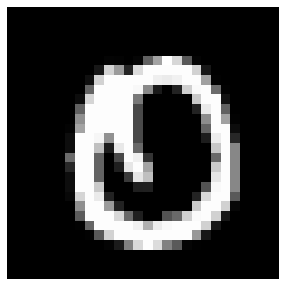

In [16]:
rnd_idx = np.random.randint(len(y_test))

print(f'La imagen mostrada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Crear Minibatches

Aquí vamos a crear minibatch para el proceso de entrenamiento. No es recomendable mandar todos los Datos para este proceso, por question de memoria, etc. Tampoco es recomendable enviar poucos Datos, ya que sería muy ineficiente el proceso.

In [17]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Ahora sí! ... Vamos para Pytorch

## Convertimos Numpy array a Pytorch (o sea para Tensores)

In [18]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())

## Usando GPU

In [21]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Estamos usando: {device}')

Estamos usando: cuda


## Calculamos accuracy

In [22]:
# model --> Nuestro modelo NEURAL

def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total 

## Loop de entrenamiento

In [25]:
def train(model, optimizer, mb_size, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')

# <font color="orange">Modelo usando Sequential</font>

In [26]:
#Instanciamos nuestro modelo

hidden1 = 1000 # Neuronas
hidden = 1000
lr = 5e-2
epochs = 100
mb_size = 4096


model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))


optimizer = torch.optim.SGD(model1.parameters(), lr=lr)


train(model1, optimizer, mb_size, epochs)

Epoch: 0, costo: 1.9202024936676025, accuracy: 0.707275390625
Epoch: 1, costo: 1.3174387216567993, accuracy: 0.78759765625
Epoch: 2, costo: 0.855911374092102, accuracy: 0.843994140625
Epoch: 3, costo: 0.6310056447982788, accuracy: 0.85595703125
Epoch: 4, costo: 0.5211655497550964, accuracy: 0.877685546875
Epoch: 5, costo: 0.44492900371551514, accuracy: 0.891357421875
Epoch: 6, costo: 0.4525982141494751, accuracy: 0.903564453125
Epoch: 7, costo: 0.4152267277240753, accuracy: 0.899169921875
Epoch: 8, costo: 0.4210869073867798, accuracy: 0.908447265625
Epoch: 9, costo: 0.33444419503211975, accuracy: 0.904296875
Epoch: 10, costo: 0.34346669912338257, accuracy: 0.91455078125
Epoch: 11, costo: 0.3667248487472534, accuracy: 0.907958984375
Epoch: 12, costo: 0.3499428331851959, accuracy: 0.9140625
Epoch: 13, costo: 0.2939586043357849, accuracy: 0.912841796875
Epoch: 14, costo: 0.31724876165390015, accuracy: 0.916748046875
Epoch: 15, costo: 0.3530997037887573, accuracy: 0.91943359375
Epoch: 16, 

In [27]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.960693359375